# Flight Traffic

### Is the sky really the limit?

#### Mapping flight patterns and high aircraft density areas in Poland.

<img src="plane.jpg" width="800"/>

### Table of contents:

1. Introduction
2. Goals
3. Basic information  
   3.1. Methodology  
   3.2. Project statistics   
   3.3. Gathered information
4. Data scraping loop    
5. Flight Traffic maps  
   5.1. Poland  
   5.2. Voivodeships  
6. Statistics  
7. Summary

## 1. Introduction

Estimating road traffic is fairly easy. The roads are constant - if new are being built, we know exactly where. You can always check information about daily traffic on google maps, targeo or other relevant map sites. And even if you can't - there are some unchangable things and patterns, like work routine traffic (around 7am and 3pm) or zones more affected than others (based on population density, infrastructure and such). Same old, same old.

But thinking about communication routes I started to wonder - **what about skies**? There are no strict sky routes, and even if there are some used more frquently than others, they are never a straight line - it's a three dimentional space after all. Much more possibilities, very little limitations (one could say - sky is the limit).

This is why I came up with the idea of **mapping aircraft routes and simulating sky traffic**. Besides pure curiosity it is an interesting subject after all - aviation is impacting our daily lifes in many different ways, such as **air quality** (both in macro and micro scale - affecting local air quality on low altitudes is an undersetimated issue), **noise pollution** (especially in lower altitudes), or even **visual aspects** (contrails).

Those ideas inspired me and kept motivated while I designed **Flight Traffic Algorithm**.

## 2. Goals

#### 1. Gather data (scraping algorithm)
The best available source for all real life information concerning aviation is <a href="https://www.flightradar24.com/"><b>Flightradar24</b></a>. This is why I've chosen to use specialised python library (**FlightRadar24API**), designed to download data from this site.

#### 2. Define and plot areas
For the information to have any clear (and relevant for me) value, I decided to narrow down analised area to **Poland** and **polish regions (voivodeships)**. It's much easier to read and evaluate information when they are presented on a smaller scale than on a global one.

#### 3. Define grid
Knowing that the amount of data will be considerable, I want to present it as a **heat maps**. In order to do so, I need to split areas to **smaller cells (grid)**, in which data can be evaluated.

#### 4. Calculate selected parameters within cells
After defining grid I need to **select parameters** that I will be mapping and **calculate their values** within the cells. This will be the basis for the heat maps.

#### 5. Plot heat maps
With prepared data the only thing left is to **plot some maps** :)

#### 6. Present selected statistics
Not all of the gathered data will be presented on maps. Some will be even calculated in the process. I can compare collected parameters in **charts** to analise certain trends and dependencies.

## 3. Basic information

### 3.1. Methodology

Flightradar24.api is designed in a way, that enables downloading and presenting selected data in current moment. This approach is **static**. I won't be able to easily track certain aircrafts in their path from starting point to their destiny. One single download will give me a map of scattered points - each of them being aircraft in it's current position. How are we going to simulate their movement then? That's easy! Remember those old action/war movies, where on every single submarine they had this big sonar, which *blipped* on every rotation showing enemy ships or missiles? Same here - I will **loop the download process** in a certain time period, so every next data transfer will show same scattered points, but in slightly different positions (due to their movement). This approach isn't perfect, but sufficient to show us what we need - **areas of increased aircraft presence**.

For data to have sufficient value, I ran data scraping loop for **7 consecutive days**. This allowed me to take into consideration both daytimes and nights, as well as week days and weekend. This is still only small portion of data - there are obviously different paths and flight frequencies between different periods of the year - but it is hopefully enough to **simulate flight routines and typical phenomena**.

All of the gathered data was stored in a csv file. Additionally, as I did in my previous projects, **csv log file was created as well** (with data such as time of download or if any error appeared).

Next step was to find **proper shape files** to place our data in desired area. It wasn't long until I've found <a href="https://data.amerigeoss.org/dataset/cod-ab-pol/resource/0a1b2c2e-ae5c-4259-9963-e1d36d2a74ca"><b>polish administrative boundaries shape files</b></a>, which made a basis for my further analysis.

With all of those elements within our reach the only thing left is to **combine them** and put them in the right places.

### 3.2. Project statistics

Thanks to the Import Log I created simultaneously with the main data file, we can see the basic statistics of **Flight Traffic** project:

In [197]:
from datetime import datetime
import pandas as pd

importLog = pd.read_csv('./ImportLog.csv', index_col=0)

statIndex = ['Start Date',
             'End Date',
             'Duration [days]',
             'Iteration [min]',
             'Total data uploads',
             'Total Number of points']
start = importLog.iloc[0]['Date']+' '+importLog.iloc[0]['Time']
end = importLog.iloc[-1]['Date']+' '+importLog.iloc[-1]['Time']
days = (datetime.strptime(end, '%d.%m.%Y %H:%M') - datetime.strptime(start, '%d.%m.%Y %H:%M')).days
it = 3
uploads = len(importLog.index)
points = importLog.iloc[-1]['NumberOfFlights']
statData = [start, end, days, it, uploads, points]

project_statistics = pd.DataFrame(index=statIndex, columns=['Data'], data=statData)
project_statistics

,Data
Start Date,27.07.2022 20:08
End Date,03.08.2022 20:17
Duration [days],7
Iteration [min],3
Total data uploads,2962
Total Number of points,247673


### 3.3. Gathered information

As I mentioned earlier, number of aircrafts and their coordinates are not the only parameters I was interested in. I decided to use this opportunity to **gather more data** for this, and possibly future projects. I focused on following information:
- altitude
- aircraft code
- flight number
- aircraft callsign
- heading
- destination airport
- origin airport
- geometry (coordinates)

Not every type of data gathered was used in this analysis. But better safe than sorry.

## 4. Data scraping loop

The most important part of the project. Data gathering. It took some time and lot of tries and errors to design proper data scraping loop. The final version, shown below, was up and running without stopping for 7 consecutive days.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import time
from shapely.geometry import Point, Polygon
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()

importLog = pd.read_csv('./ImportLog.csv', index_col=0)
loop = 0
while True:
    loop += 1
    try:
        coordinates = gpd.read_file('./coordinates.shp')
        pl_path = './Poland/pol_adm_gov/pol_admbnda_adm0_gov_v02_20220414.shp'
        pl = gpd.read_file(pl_path)
        zones = fr_api.get_zones()
        zone = zones['europe']['subzones']['poland']
        bounds = fr_api.get_bounds(zone)
        flights = fr_api.get_flights(bounds = bounds)
        for flight in flights:
            if pl.contains(Point(flight.longitude, flight.latitude)).bool() == True:
                flightdata = {'date':[time.strftime('%d.%m.%Y')],
                      'time':[time.strftime('%H:%M')],
                      'altitude':[flight.altitude],
                      'code':[flight.aircraft_code],
                      'number':[flight.number],
                      'callsign':[flight.callsign],
                      'heading':[flight.heading],
                      'dest':[flight.destination_airport_iata],
                      'orig':[flight.origin_airport_iata],
                      'geometry': [Point(flight.longitude, flight.latitude)]}
                flightcoordinates = gpd.GeoDataFrame(flightdata, crs="EPSG:4326")
                coordinates = pd.concat([coordinates, flightcoordinates], ignore_index=True)
            else:
                pass
        importLog.loc[-1]=[time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), len(coordinates.index)]
        importLog = importLog.reset_index(drop=True)
        importLog.to_csv('ImportLog.csv')
        print('Date: {}, Time: {}, loop number: {}, number of flights: {}'.format(time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), loop,len(coordinates.index)))
        coordinates.to_file('./coordinates.shp')
        time.sleep(180)
    except:
        importLog.loc[-1]=[time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), 'error']
        importLog = importLog.reset_index(drop=True)
        importLog.to_csv('ImportLog.csv')
        print('Date: {}, Time: {}, loop number: {}, error'.format(time.strftime('%d.%m.%Y'), time.strftime('%H:%M'), loop))
        time.sleep(180)

## 5. Flight traffic maps

### 5.1. Poland

Now to the main course! We can finally start making some **flight maps**!

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from FlightRadar24.api import FlightRadar24API
import shapefile as shp
import shapely
import time
from shapely.geometry import Point, Polygon
import geopandas as gpd
from scipy import ndimage
fr_api = FlightRadar24API()

In [123]:
#Reading data
coordinates = gpd.read_file('./coordinates.shp')
coordinates = coordinates.drop(coordinates[coordinates['altitude']=='0'].index)
coordinates['altitude'] = coordinates['altitude'].apply(lambda x: int(x))

With minor adjustments, **coordinates data** is ready to place on our maps.

Now we should add **Poland administrative boundaries** to our equation, narrowing down our analysis to the desired area.

In [124]:
#Reading Poland shape file
pl_path = './Poland/pol_adm_gov/pol_admbnda_adm0_gov_v02_20220414.shp'
pl = gpd.read_file(pl_path)

#Reading polish Voivodeships shape file
woj_path = './Poland/pol_adm_gov/pol_admbnda_adm1_gov_v02_20220414.shp'
woj = gpd.read_file(woj_path)

In order to create heat maps we need to divide our area into smaller cells. We will make this by **putting a grid on the defined shapes**. Number and size of cells will depend on the size of area boundaries.

With grid created we can finally put coordinates data onto it and find out how many points are contained in each grid cell.

We will focus on two paramters in this analysis - **number of points** and their **altitude**.

In [126]:
#Creating polygon grid
xmin, ymin, xmax, ymax= pl.total_bounds
n_cells=260
cell_size = (xmax-xmin)/n_cells
crs="EPSG:4326"
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

#defining number of points within cells
cellValues = cell.sjoin(coordinates)['geometry'].value_counts()
cellData = {'geometry':cellValues.index, 'points':cellValues.values}
cellJoin = gpd.GeoDataFrame(cellData, crs="EPSG:4326")
heatMapPL = gpd.sjoin(cell,cellJoin, predicate='contains', how='left').fillna(0)

# defining mean altitude within cells
altMean = cell.sjoin(coordinates).groupby(cell.sjoin(coordinates).index)['altitude'].mean()
altData = {'geometry':[cell.iloc[i][0] for i in altMean.index], 'mean_altitude':altMean.values}
altJoin = gpd.GeoDataFrame(altData, crs="EPSG:4326")
altMapPL = gpd.sjoin(cell, altJoin, predicate='contains', how='left').fillna(0)

This is enough preparation that will allow us to plot desired heat maps. Before we do that though, let's take a look on a **raw scattered points**. It should show us general tendencies and flight patterns over Poland.

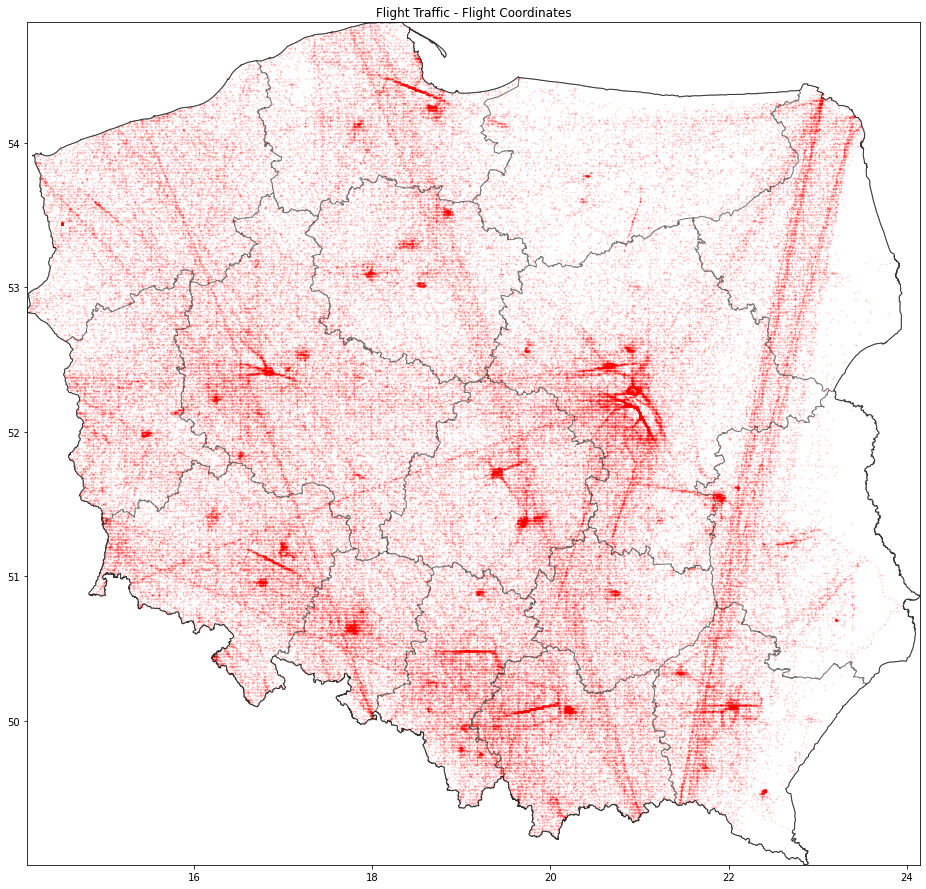

In [128]:
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
coordinates.plot(ax=ax, marker='o', color='red', markersize=1, alpha=0.1)
woj.plot(ax=ax, alpha=0.3, facecolor="none")
pl.plot(ax=ax, alpha=0.7, facecolor="none")

ax.set_title('Flight Traffic - Flight Coordinates')
plt.show()

This already looks interesting! We can easily distinguish areas that are much more frequently used than others. There is really big point cluster near Warsaw, as well in other big cities. High point concentration will be present also near airports.

Now let's plot our heat maps. We will plot two maps - one showing flight traffic, other mean altitude.

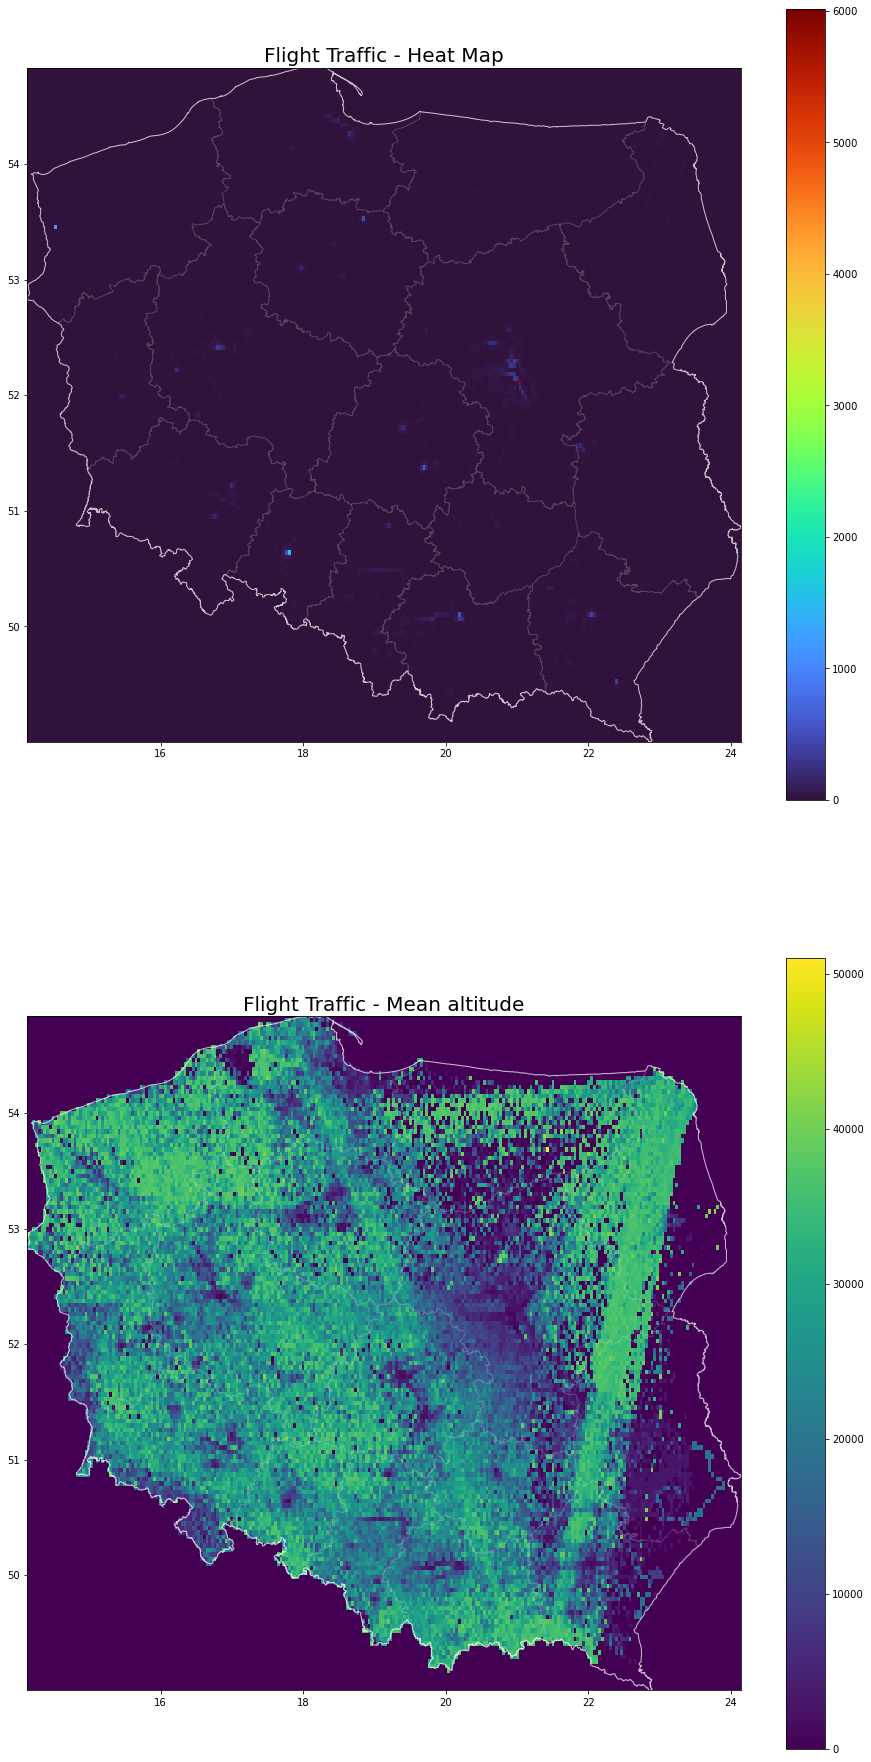

In [136]:
fig, ax = plt.subplots(2, figsize=(16,32))

ax[0] = plt.subplot(2,1,1)
ax[0].set_aspect('equal')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
heatMapPL.plot(ax=ax[0], column='points', cmap='turbo', legend=True)
woj.plot(ax=ax[0], alpha=0.1, facecolor="none", edgecolor="white")
pl.plot(ax=ax[0], alpha=0.7, facecolor="none", edgecolor="white")
ax[0].set_title('Flight Traffic - Heat Map', size=20)

ax[1] = plt.subplot(2,1,2)
ax[1].set_aspect('equal')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
altMapPL.plot(ax=ax[1], column='mean_altitude', cmap='viridis', legend=True)
woj.plot(ax=ax[1], alpha=0.1, facecolor="none", edgecolor="white")
pl.plot(ax=ax[1], alpha=0.7, facecolor="none", edgecolor="white")
ax[1].set_title('Flight Traffic - Mean altitude', size=20)

plt.show()

Flight Traffic map doesn't look as spectacular as I was hoping. **The difference between areas with high and low flight counts is too big**, which result in highliting only few areas, the biggest one being, as suspected, Warsaw and it's surroundings. The map looks almost like a constellation on a night sky - with single highlited points.

The other map looks different though. It is a map, that presents **mean altitude within grid cells** - the darker the color, the lower planes fly. This is the opposite outcome to the flight traffic map in a way - places with lowest mean altitude are either **airports** (so places with most aircrafts per cell) or **areas with no flight paths at all**. It also shows us certain flight patterns and common routes.

### 5.2. Voivodeships

To see **more diverse maps** we will split it into separate sections - 16 polish voivodeships. This should scale everything down enough to show more traffic information, relevant to certain section.

While making plot loops, we will use this opportunity to **collect selected statistical data** - they will come in handy in the next chapter of this project.

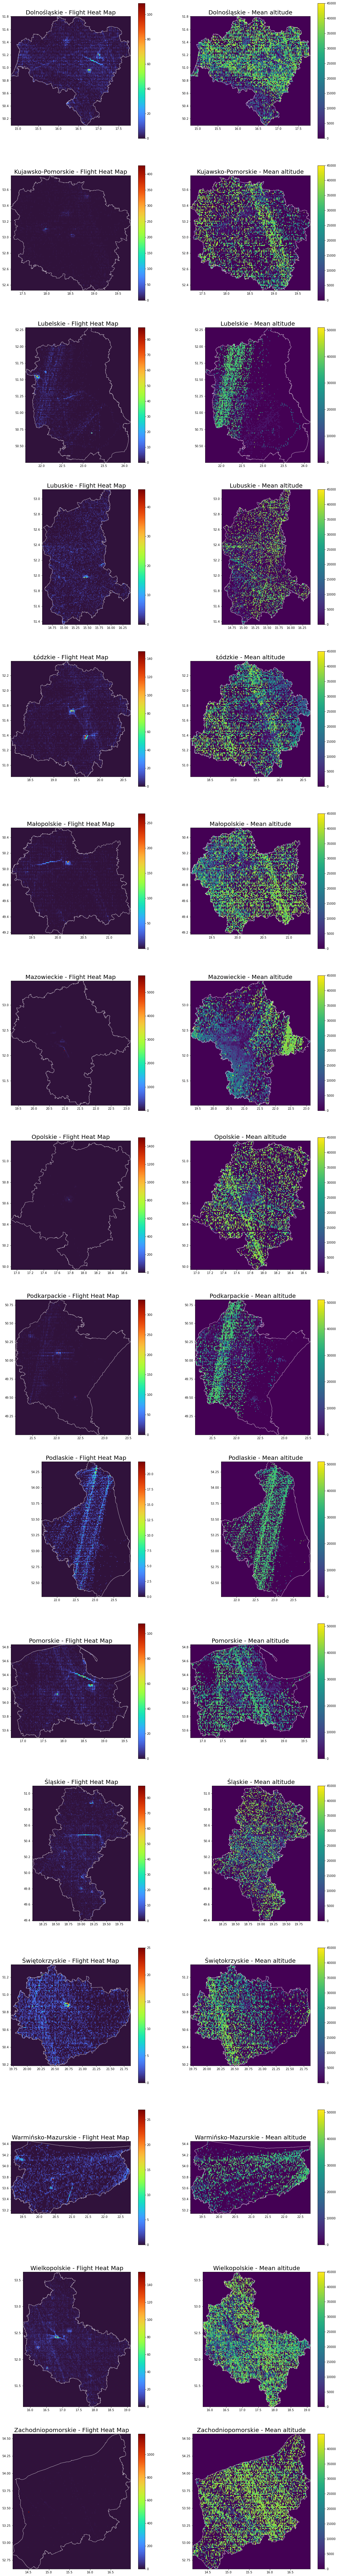

In [237]:
vStats = pd.DataFrame({"Name":[],
                       "TotalCells":[],
                       "CellArea":[],
                       "TotalFlights":[],
                       "MaxCell":[],
                       "AvgCell":[],
                       "AvgAltitude":[],
                       "FreeSkyCells":[],
                       "FreeSkyArea [%]":[]})

fig, axs = plt.subplots(32, figsize=(20,160))
pos1 = 1
pos2 = 2
i = 0
j = 1

for v in woj['ADM1_PL'].to_list():
    voivodeship = woj[woj['ADM1_PL']==v]
    vcoord = coordinates.sjoin(voivodeship).drop(['index_right'], axis=1)
    xmin, ymin, xmax, ymax= voivodeship.total_bounds

    #grid prep
    n_cells=180
    cell_size = (xmax-xmin)/n_cells
    crs="EPSG:4326"
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    #number of flights within cells
    vcell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    vcellValues = vcell.sjoin(vcoord)['geometry'].value_counts()
    vcellData = {'geometry':vcellValues.index, 'points':vcellValues.values}
    vcellJoin = gpd.GeoDataFrame(vcellData, crs="EPSG:4326")
    vheatMap = gpd.sjoin(vcell,vcellJoin, predicate='contains', how='left').fillna(0)
    #mean altitude within cells
    valtMean = vcell.sjoin(vcoord).groupby(vcell.sjoin(vcoord).index)['altitude'].mean()
    valtData = {'geometry':[vcell.iloc[i][0] for i in valtMean.index], 'mean_altitude':valtMean.values}
    valtJoin = gpd.GeoDataFrame(valtData, crs="EPSG:4326")
    valtMap = gpd.sjoin(vcell, valtJoin, predicate='contains', how='left').fillna(0)
    
    #statistics
    allC = vheatMap.drop(['index_right'], axis=1).sjoin(voivodeship)
    allA = valtMap.drop(['index_right'], axis=1).sjoin(voivodeship)
    totalc = len(allC.index)
    totalf = len(vcoord.index)
    maxc = int(allC['points'].max())
    avgc = round(totalf/totalc,2)
    avga = round(allA['mean_altitude'].mean(),2)
    fsc = len(allC[allC['points']==0].index)
    fsa = round(fsc/totalc*100,2)
    vStats.loc[-1]=[v,totalc,totalf,maxc,avgc,avga,fsc,fsa]
    vStats.index = vStats.index+1
    vStats = vStats.sort_index()
    
    #plot prep
    axs[i] = plt.subplot(16,2,pos1)
    axs[i].set_xlim(xmin, xmax)
    axs[i].set_ylim(ymin, ymax)
    axs[i].set_title(v+' - Flight Heat Map', size=20)
    vheatMap.plot(ax=axs[i], column='points', cmap='turbo', legend=True)
    voivodeship.plot(ax=axs[i], alpha=0.7, facecolor="none", edgecolor="white")
    
    axs[j] = plt.subplot(16,2,pos2)
    axs[j].set_xlim(xmin, xmax)
    axs[j].set_ylim(ymin, ymax)
    axs[j].set_title(v+' - Mean altitude', size=20)
    valtMap.plot(ax=axs[j], column='mean_altitude', cmap='viridis', legend=True)
    voivodeship.plot(ax=axs[j], alpha=0.7, facecolor="none", edgecolor="white")
    
    pos1+=2
    pos2+=2
    i+=2
    j+=2

plt.show()

As suspected, both flight traffic maps and altitude maps are **much clearer**, showing the **specifics of given regions**. Some are highly spread out, without clear patterns (Świętokrzyskie), some show clear paths and movement routines (Podlaskie, Pomorskie, Warmińsko-mazurskie) and others show only singular, high density points (Zachodniopomorskie, Opolskie).

## 6. Statistics

This is how the **statistics table** with gathered data looks like:

In [238]:
vStats

,Name,TotalCells,TotalFlights,MaxCell,AvgCell,AvgAltitude,FreeSkyCells,FreeSkyArea [%]
0,Zachodniopomorskie,12740,12537,1181,0.98,15512.51,6133,48.14
1,Wielkopolskie,11976,23131,155,1.93,18857.09,3132,26.15
2,Warmińsko-Mazurskie,8228,4302,27,0.52,7840.59,5357,65.11
3,Świętokrzyskie,10723,7870,25,0.73,10355.85,5928,55.28
4,Śląskie,13992,12574,88,0.90,11139.39,7059,50.45
5,Pomorskie,9810,10586,108,1.08,10777.22,4922,50.17
6,Podlaskie,16360,8381,22,0.51,9338.92,11701,71.52
7,Podkarpackie,12979,10415,338,0.80,6703.20,8591,66.19
8,Opolskie,12628,10579,1496,0.84,11347.42,7259,57.48
9,Mazowieckie,10625,34692,5703,3.27,10197.76,3617,34.04


Most of the data is self-explainatory. The new ones are **FreeSkyCells** and **FreeSkyArea**. In every analysed voivodeship, **cells without single flight point** were counted (FreeSkyCells) and then compared to other cells, which resulted in **FreeSkyArea ratio** (FreeSkyCells to number of all cells in the voivodeship). The highest the FreeSkyArea value, the "clearest" sky - meaning the biggest area **without aircraft presence**.

This is very decent set of data! Now let's make a good use of it and present selected parameters on a charts:

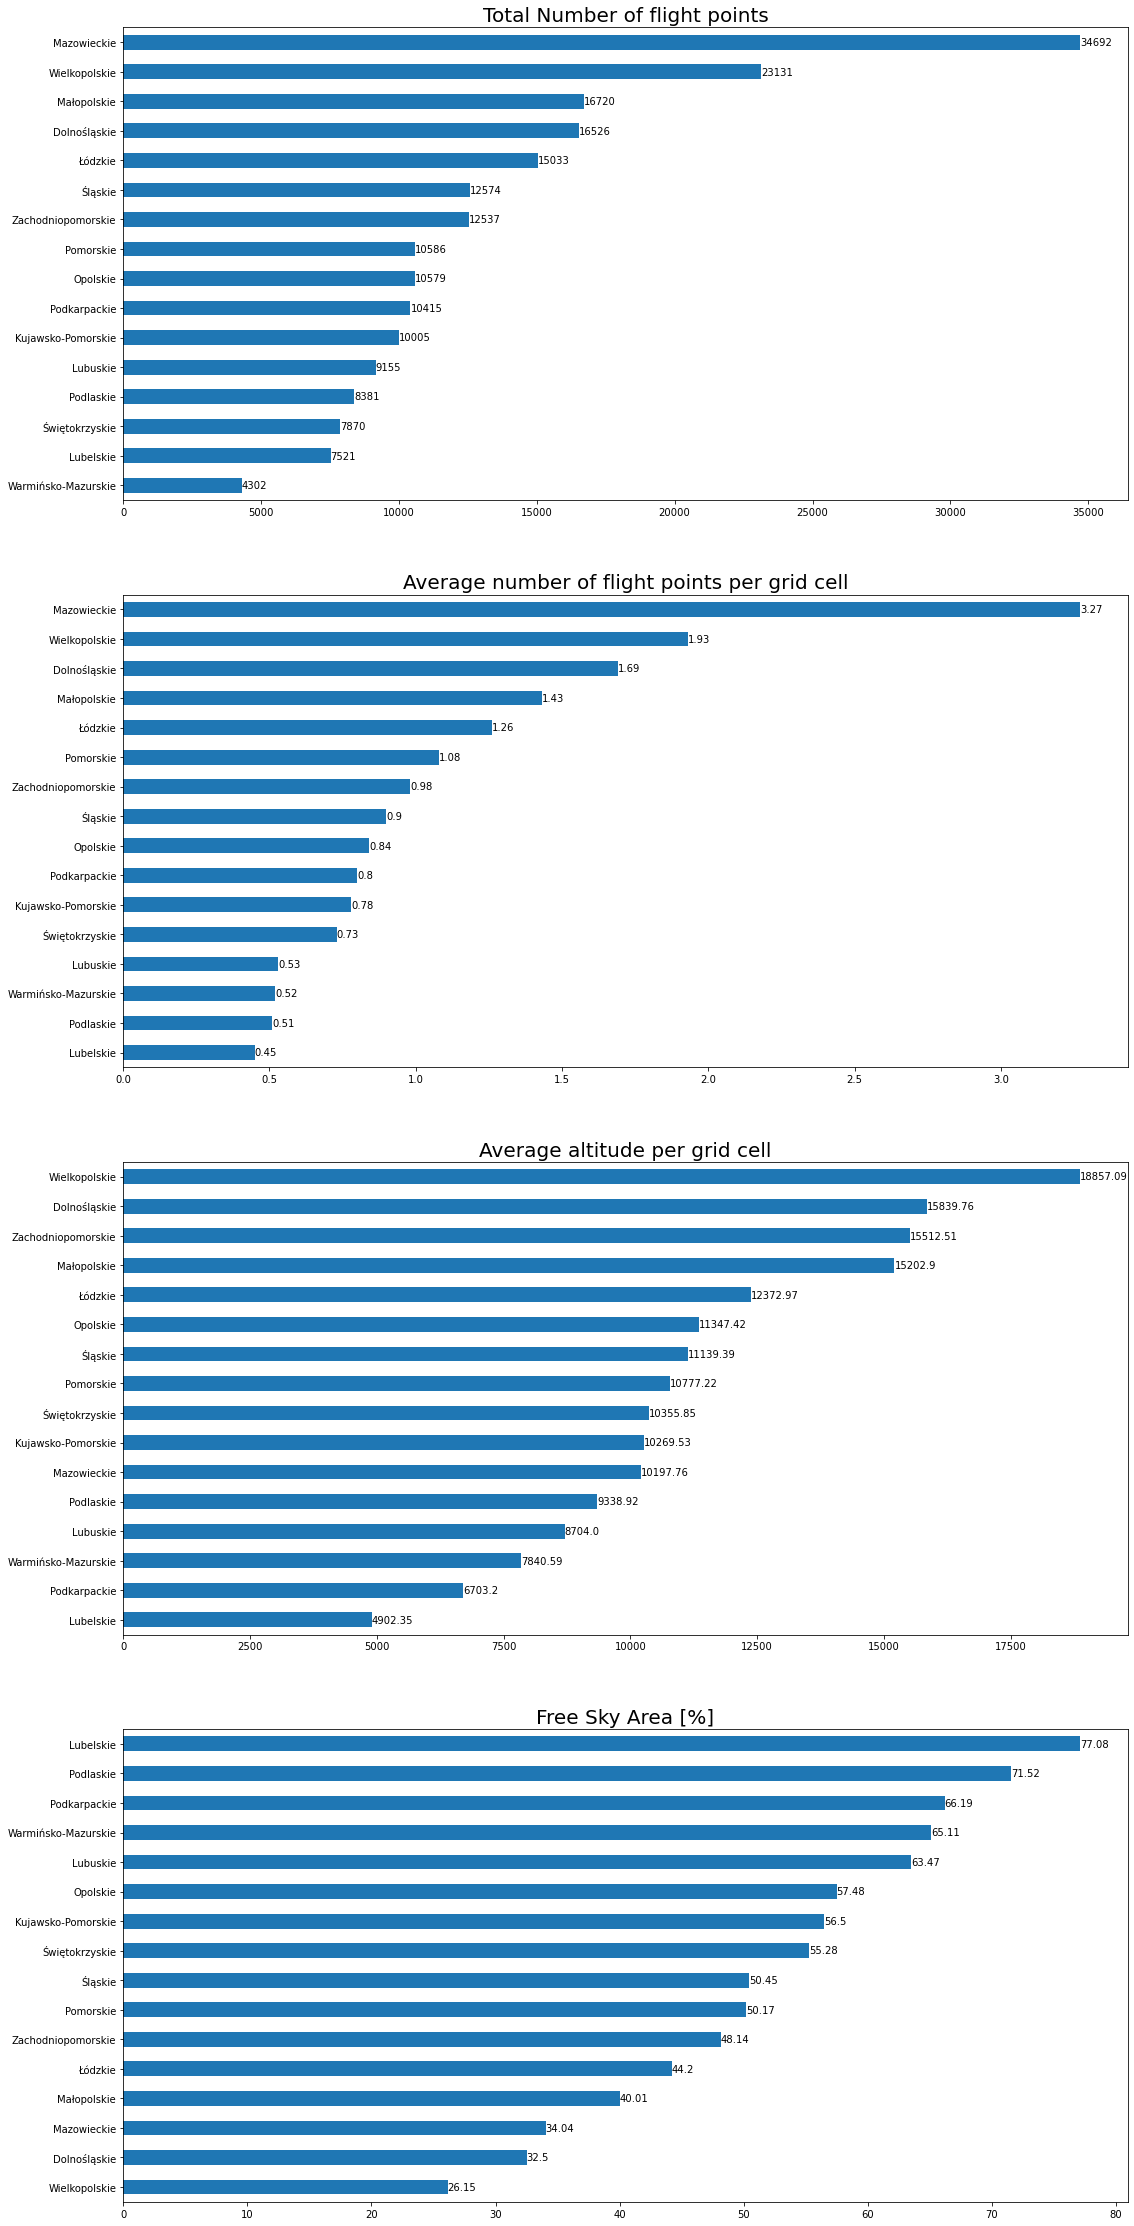

In [252]:
tf = pd.Series(index=vStats['Name'].values, data=vStats['TotalFlights'].tolist()).sort_values()
ac = pd.Series(index=vStats['Name'].values, data=vStats['AvgCell'].tolist()).sort_values()
aa = pd.Series(index=vStats['Name'].values, data=vStats['AvgAltitude'].tolist()).sort_values()
fsa = pd.Series(index=vStats['Name'].values, data=vStats['FreeSkyArea [%]'].tolist()).sort_values()

factors = [tf,ac,aa,fsa]
titles = ['Total Number of flight points',
          'Average number of flight points per grid cell',
          'Average altitude per grid cell',
          'Free Sky Area [%]'          
         ]

fig, axs = plt.subplots(4, figsize=(18,40))
i = 0
pos = 1

for title, factor in zip(titles, factors):
    axs[i] = plt.subplot(4,1,pos)
    axs[i] = factor.plot(kind='barh')
    axs[i].set_title(title, size=20)
    for j in range(len(factor.index)):
        axs[i].text(factor[j], j, factor[j], va='center')
    pos+=1
    i+=1
plt.show()

Analysing those charts we can see that **Mazowieckie** voivodeship stands out as the **most congested of them all** - with the highest total number of flight points and the highest average number of flight points per cell.

The voivodeship with the **clearest sky** turned out to be **Lubelskie** with astounding result of **77.08%**. We can also notice (both from the maps and statistics) that voivodeships that are **located in the east** (Podlaskie, Lubelskie, Podkarpackie) have considerable part of their area **free of any flight paths**. This is however an unusual situation. In the period when the data was scraped from the source (27.07.2022 - 03.08.2022) it was already 5 months into Russian invasion in Ukraine. All flight paths to the east were cancelled, **separating countries located to the east** (especially Belarus and Russia) from the Europe.

The moment I plotted my flight maps I thought I was capturing a brief moment in history, where this separation is really well visualised. Unfortunately, the moment was not brief. Today, when I am finishing my project, it is January 2023 and the war is far from over.

## 7. Summary

In the end, the project was a success. I managed to fulfill **all of my goals**, gathering considerable amount of data, creating flight traffic and altitude maps and presenting selected statistical parameters on charts.

With **given time** (and motivation), much more **detailed analysis** can be conducted (including different seasons of the year or even different years in a long run). The results can be appealing to various science fields, from **environmental** ones to **economic**, **social** or even **history**, as the ongoing war on the east will surely make its way to the future history books.

For me this project satisfied my interest in the fligh traffic phenomenon in my country, gave me much needed opportunity to improve my data analysis and geomapping skills and ignited curiosity in the topic of travel and behavioral patterns connected to the geolocation.

I hope to explore similar topics in the future.